# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Loading-the-data" data-toc-modified-id="Loading-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading the data</a></div><div class="lev2 toc-item"><a href="#Extracting-data-from-each-worm." data-toc-modified-id="Extracting-data-from-each-worm.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Extracting data from each worm.</a></div><div class="lev3 toc-item"><a href="#Exploratory-analysis-of-animal-zero." data-toc-modified-id="Exploratory-analysis-of-animal-zero.-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Exploratory analysis of animal zero.</a></div>

In [1]:
# General usage libraries
import os

# Numerical workhorses
import pandas as pd
import numpy as np
import scipy as scipy
import scipy.io as sio
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA

# Plotting 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import FuncFormatter
# Nice plots
import seaborn as sns

# favorite Seaborn settings for notebooks
rc={'lines.linewidth': 2, 
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'grid.color' : 'a6a6a6',
    'lines.linewidth': 2,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'xtick.major' : 13,
    'xtick.labelsize': 'large',
    'ytick.labelsize': 13,
    'font.family': 'Lucida Sans Unicode',
    'grid.linestyle': ':',
    'grid.linewidth': 1.5,
    'mathtext.fontset': 'stixsans',
    'mathtext.sf': 'sans',
    'legend.frameon': True,
    'legend.fontsize': 13}

plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
plt.rc('mathtext', fontset='stixsans', sf='sans')
sns.set_style('darkgrid', rc=rc)
sns.set_palette("colorblind", color_codes=True)
sns.set_context('notebook', rc=rc)


%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# Loading the data

Let's load and tidy the input GCaMP data.

In [2]:
# Define imaging rate
fps = 30.3 # frame / sec

# Initialize list to save frames
frames = []

# Loop through the files in directory
for root, dirs, files in\
    os.walk('../input/kato_data/nostim', topdown=False):
    for no_animals, file in enumerate(files):
        # Load the .mat file
        mat = sio.loadmat('../input/kato_data/nostim/' + file)
        # Convert neuron traces to numpy array
        npmat = np.array(mat['neuronTraces'].tolist())
        # Smooth the traces with a savgol filter
        smoothnpmat = savgol_filter(npmat, int(np.floor(fps) + 1), 2)
        # Extract neuron names to name columns in DataFrame
        columns = [a[0] for a in mat['neuronNames'][0]]
        # Generate pandas data frame with fluorescence traces
        temp = pd.DataFrame(npmat)
        # Generate data frame for smooth data
        temp2 = pd.DataFrame(smoothnpmat)
        # Define column names of data frames
        temp.columns = columns
        temp2.columns = columns
        
        # Add frame number using the index of the data frame
        temp['frame'] = temp.index
        
        # Melt the DataFrames into a tidy format
        melted_df = temp.melt(id_vars='frame', var_name='Neuron',
                         value_name='Fluorescence')
        smooth_melted_df = temp2.melt(var_name='Neuron',
                         value_name='Fluorescence')
        # Add column with animal index
        melted_df['animal'] = no_animals
        # Add smooth fluorescence
        melted_df['smooth_fluor'] = smooth_melted_df['Fluorescence']
        # Sort by neuron and frame
        melted_df.sort_values(['Neuron', 'frame'], inplace=True)
        # Put frames into a list for concatenation
        frames += [melted_df]

# Concatenate all DataFrames for each animal
df = pd.concat(frames)
df.head()

/Users/dangeles/anaconda3/lib/python3.5/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


,frame,Neuron,Fluorescence,animal,smooth_fluor
55062,0,AIBL,1.354239,0,0.638887
55063,1,AIBL,1.296302,0,0.603887
55064,2,AIBL,1.265741,0,0.598448
55065,3,AIBL,1.156298,0,0.549912
55066,4,AIBL,1.091768,0,0.569109


Since not all neurons were labeled for each of the animals, let's identify the subset of neurons that were detected in all 3 samples.

In [3]:
# figure out subset of neurons with replicates:
# Initialize list to save neurons labeled in all samples
neurons_with_replicates = []
# Loop through data frames grouped by column neuron
for neuron, group in df.groupby('Neuron'):
    # List the index of unique animals
    animals = group.animal.unique()
    if len(animals) == df.animal.max() + 1:
        neurons_with_replicates += [neuron]
neurons_with_replicates = np.sort(neurons_with_replicates)
print(neurons_with_replicates)

['AIBL' 'AIBR' 'ALA' 'AVAL' 'AVAR' 'AVBL' 'AVBR' 'AVER' 'RIBL' 'RID'
 'RIML' 'RIMR' 'RIVL' 'RIVR' 'RMED' 'RMEL' 'RMER' 'SMDVR' 'VB01' 'VB02']


## Extracting data from each worm.

Given this list of neurons measured for all samples let's define a simple function that takes this list and an animal index and extracts the sub-DataFrame.

In [4]:
def get_data_from_worm(df, sample_idx, normed=True, smooth=False,
                       neuron_list=neurons_with_replicates):
    '''
    Extracts the data for a given sample containing only the neurons listed in
    neuron_list and returns a matrix with neurons as columns and frame as rows
    Parameters
    ----------
    df : Pandas DataFrame.
        Tidy data frame containing the neuron data with
        - Fluorescence values
        - Animal index
        - Neuron name
        - Frame number
    sample_idx : int.
        Sample index.
    normed : bool.
        Boolean indicating if the fluorescence data should be normalized before
        returning.
    smooth : bool.
        Boolean indicating if the raw data or the smooth data is to be returned.
    neuron_list : array-like.
        List of neurons to be included in the data frame
    '''
    # Take only rows containing the neurons included in neuron_list
    a = (df.Neuron.isin(neuron_list))
    
    # Extract data for desired sample
    if not smooth:
        single_animal = df[(df.animal == sample_idx) & a][['frame',
                                                           'Neuron', 
                                                           'Fluorescence']]
    else:
        single_animal = df[(df.animal == sample_idx) & a][['frame',
                                                           'Neuron', 
                                                           'smooth_fluor']]
    # Sort data by neuron name and frame number
#     single_animal.sort_values(['Neuron', 'frame'], inplace=True)
    
    # Pivot data frame
    single_animal = single_animal.pivot(index='frame', columns='Neuron')
    
    # Convert data into a matrix
    data = single_animal.as_matrix()
    
    if normed:
        data = (data - data.mean(axis=0))/data.std(axis=0)
    return data

### Exploratory analysis of animal zero.

Let's look at a single sample to build intuition on the structure of the data.

In [5]:
# Extract data from animal index 0
data0 = get_data_from_worm(df, 0, smooth=True)

Let's plot the neuronal traces over time as a heatmap.

/Users/dangeles/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(30,0.5,'neuron number')

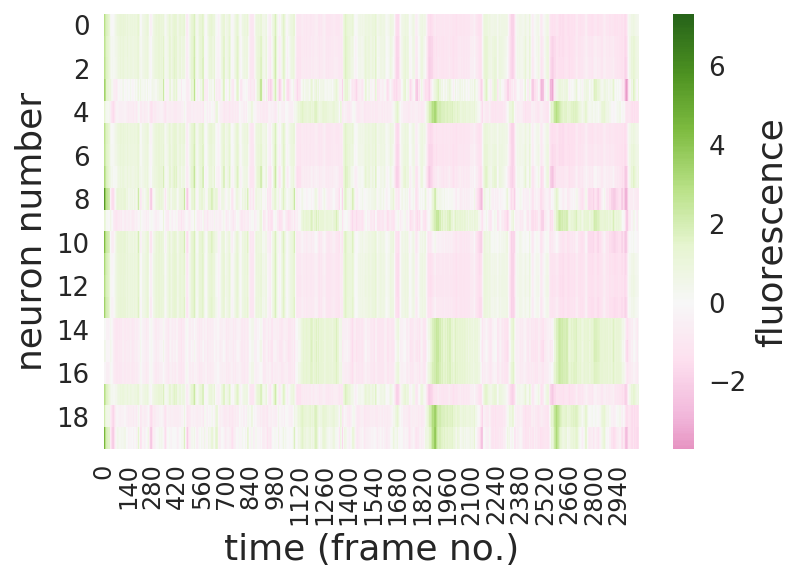

In [6]:
# Plot heat map of fluorescence centering the color bar at 0
sns.heatmap(data0.T, cmap='PiYG', center=0, cbar_kws={'label':'fluorescence'})
# Rotate ticks
_ = plt.yticks(rotation=0)
# Label axis
plt.xlabel('time (frame no.)')
plt.ylabel('neuron number')

There is definitely interesting structure in this heat map. Let's try clustering the most related neurons using `seaborn` clustermap on the convariance matrix.

/Users/dangeles/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


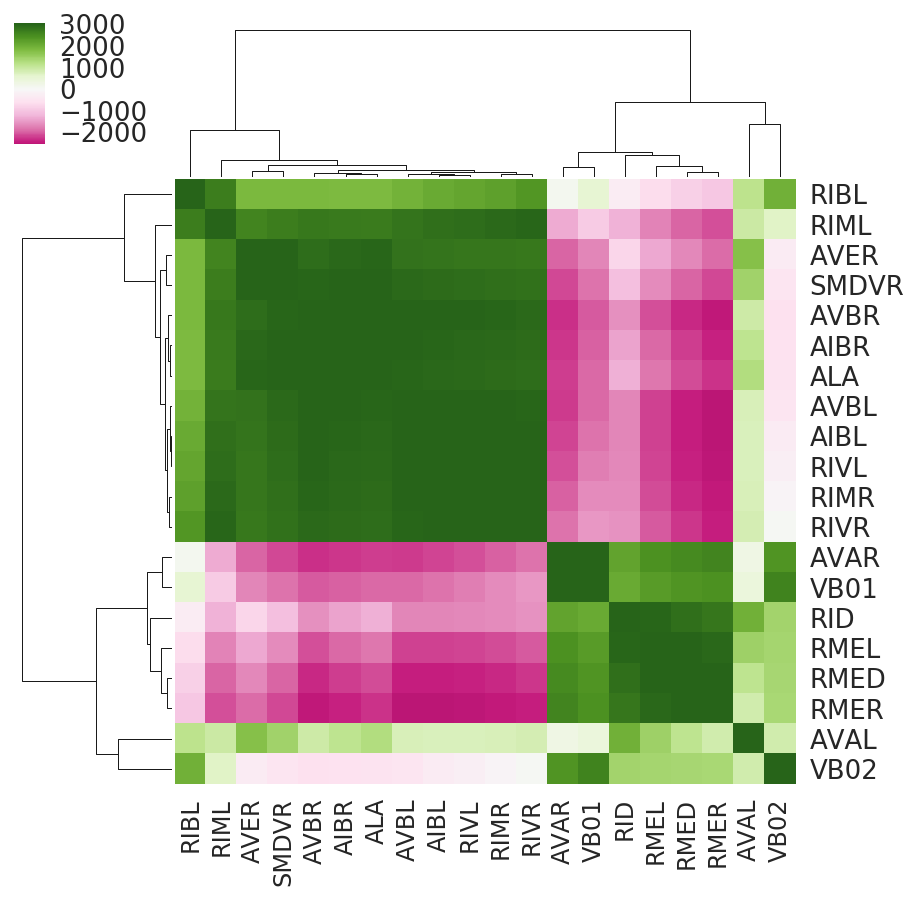

In [7]:
# Compute the covariance matrix
covar = data0.T.dot(data0)

covar = pd.DataFrame(covar, columns=neurons_with_replicates,
                     index=neurons_with_replicates)
cg = sns.clustermap(covar.as_matrix(), cmap="PiYG", figsize=(7, 7),
                    **{'center':0})
temp = cg.ax_heatmap.get_xticklabels()

# Generate dictionary to convert numerical label to neuron name
neuron_dict = {i: neurons for i, neurons in enumerate(neurons_with_replicates)}

# Extract labels from both axis
xlabels = [item.get_text() for item in cg.ax_heatmap.xaxis.get_ticklabels()]
ylabels = [item.get_text() for item in cg.ax_heatmap.yaxis.get_ticklabels()]

# Map labels to neuron name given the dictionary
cg.ax_heatmap.xaxis.set_ticklabels([neuron_dict[y] for y in
                                    [int(x) for x in xlabels]])
cg.ax_heatmap.yaxis.set_ticklabels([neuron_dict[y] for y in
                                    [int(x) for x in ylabels]])

# Rotate labels in x axis
_ = plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)

In [8]:
data1 = get_data_from_worm(df, 1)
data2 = get_data_from_worm(df, 2)
subset = data1
pca = PCA(3)
pca.fit(subset)
print(pca.explained_variance_ratio_)
W = pca.components_

[0.51130741 0.24474153 0.09349337]


In [9]:
tD0 = W.dot(data0.T)
tD1 = W.dot(data1.T)
tD2 = W.dot(data2.T)

/Users/dangeles/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


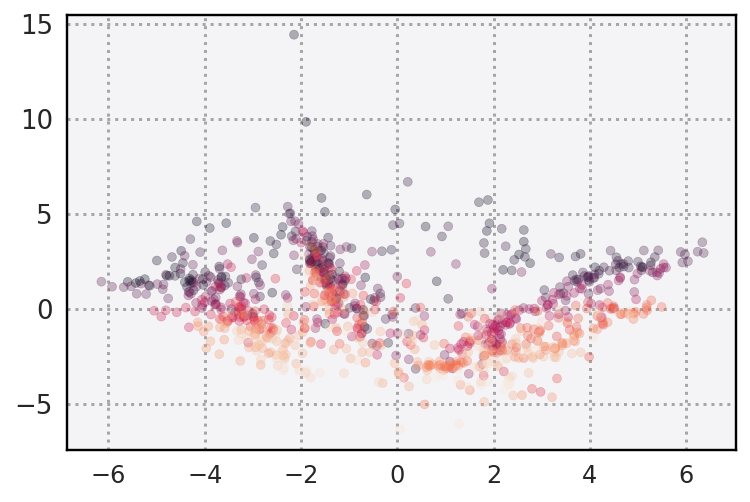

In [10]:
subsample = 10
color = np.linspace(0, 1, len(tD0[0, ::subsample]))
color1 = np.linspace(0, 1, len(tD1[0, ::subsample]))
color2 = np.linspace(0, 1, len(tD2[0, ::subsample]))

plt.scatter(tD0[0, ::subsample], tD0[1, ::subsample], s=20, alpha=0.3, c=color)
plt.scatter(tD1[0, ::subsample], tD1[1, ::subsample], s=20, alpha=0.3, c=color1)
plt.scatter(tD2[0, ::subsample], tD2[1, ::subsample], s=20, alpha=0.3, c=color2)

/Users/dangeles/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


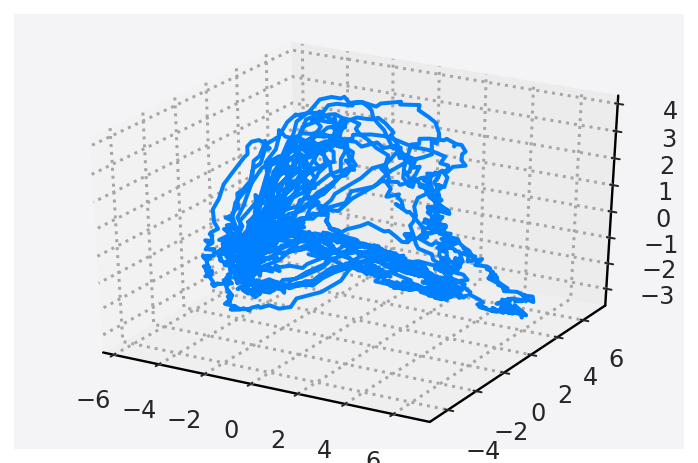

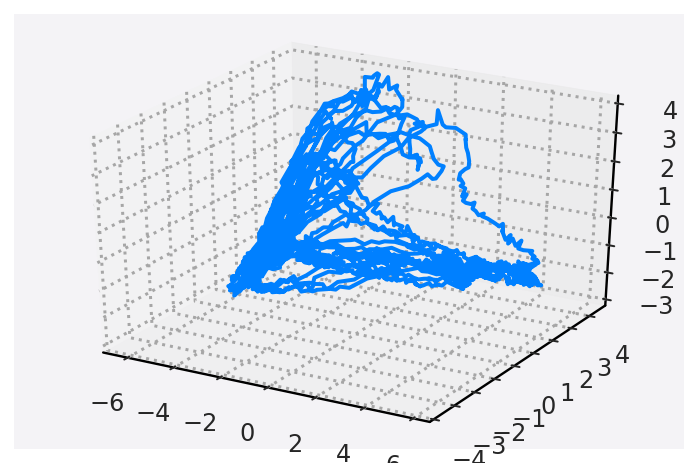

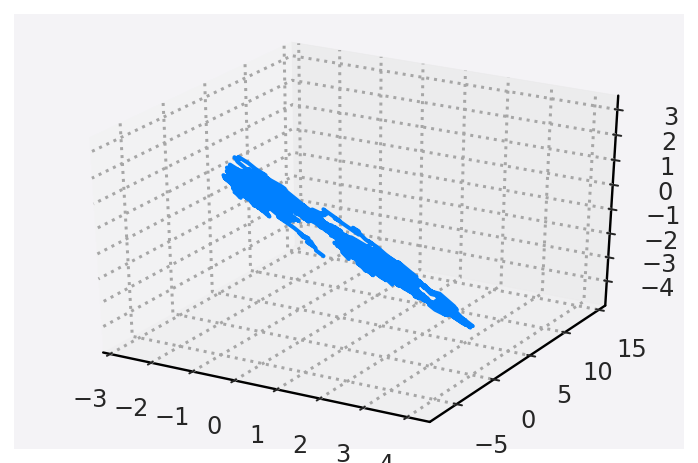

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3d(tD, ax=None, color='k', subsample=5, **kwargs):
    tD = tD[:, ::subsample]
    color = np.linspace(0, 1, len(tD))
    x = tD[0, :]
    y = tD[1, :]
    z = tD[2, :]
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(x, y, z, zdir='z',  c=color, **kwargs)
    else:
        ax.plot(x, y, z, zdir='z',  c=color, **kwargs)
    return ax

ax = plot3d(tD1, ax=None, color=color, subsample=1)
ax = plot3d(tD2, ax=None, color=color, subsample=1)
ax = plot3d(tD0, ax=None, color=color, subsample=1)

/Users/dangeles/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


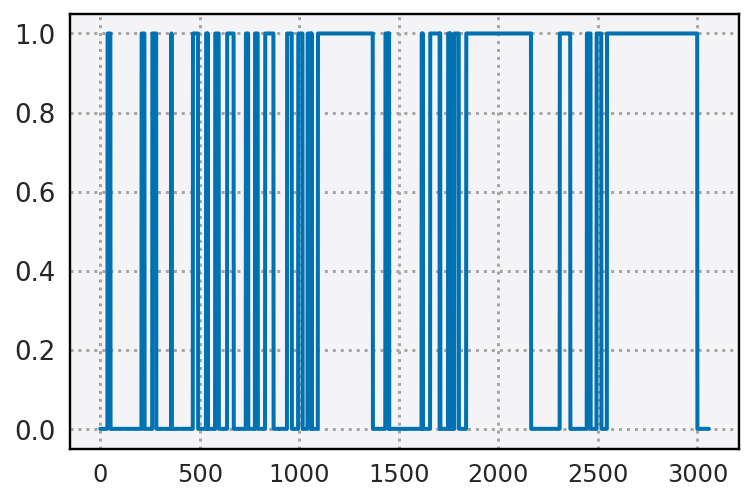

In [28]:
plt.plot(tD0[0, :] > np.median(tD0[0, :]))

In [54]:
ones = 1*(tD0[0, :] > np.median(tD0[0, :]))
model = hmm.MultinomialHMM(n_components=2, algorithm='map')
model.fit(ones)

/Users/dangeles/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


MultinomialHMM(algorithm='map', init_params='ste', n_components=2, n_iter=10,
        params='ste',
        random_state=<mtrand.RandomState object at 0x110b77750>,
        startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False)

In [55]:
model.emissionprob_

array([[0.41765147, 0.58234853],
       [0.58314703, 0.41685297]])

In [56]:
model.transmat_

array([[0.55538625, 0.44461375],
       [0.44740564, 0.55259436]])

In [67]:
model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100, algorithm='map')
model.fit(tD0[0, :].reshape(-1, 1))

/Users/dangeles/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/dangeles/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/dangeles/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/dangeles/anaconda3/lib/python3.5/s

GaussianHMM(algorithm='map', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=2, n_iter=100, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

In [68]:
model.transmat_

array([[0.99229437, 0.00770563],
       [0.01115614, 0.98884386]])

In [71]:
model.means_

array([[-1.3674437 ],
       [ 1.98086768]])

/Users/dangeles/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['Lucida Sans Unicode'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


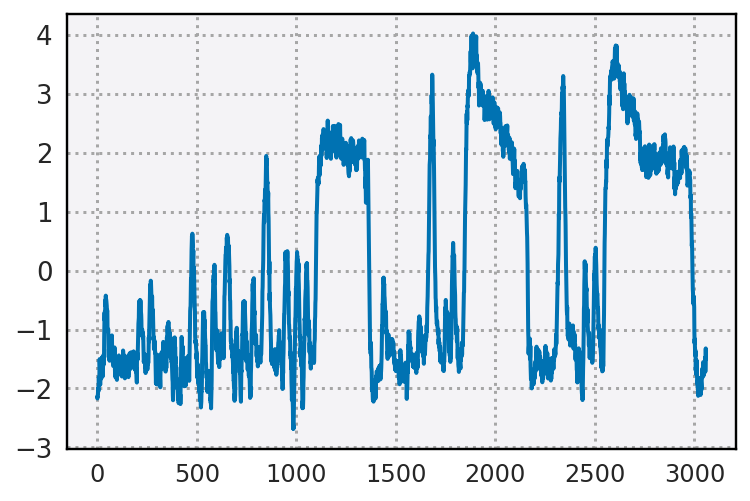

In [69]:
plt.plot(tD0[0,:])a

In [72]:
.99/(1-0.99)

98.99999999999991

In [74]:
1*98.999

98.999